In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
from datetime import datetime

In [3]:
# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.topic_comparison import compare_topic_queryset, save_res
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

from utils.topic_comparison import compare_topic_queryset, save_res, sort_matrix, draw_score_matrix
from utils.topic_comparison import save_topic_list_as_table, draw_bipartite_topic_graph, bipartite_graph_from_matrix

In [4]:
user1, created =  User.objects.get_or_create(username='leey', email='lee@mcc-berlin.net')
user1.save()

In [6]:
# ParlPeriod have no associated start and end dates
pm.ParlPeriod.objects.get(n=18).end_date

In [5]:
# From wikipedia
start_date = datetime.strptime("2013-9-22", "%Y-%m-%d")
end_date = datetime.strptime("2017-10-24", "%Y-%m-%d")

In [5]:
# simple search for utterances
par_search_tei, created = pm.Search.objects.get_or_create(
                title="Kohle pdf utterance all",
                text='(?<!Europäische Gemeinschaft für )kohle(?!nwasser)(?!nstoff)(?!ndiox)(?!nmonox)(?!rnte)',
                creator=user1,
                #start_date = start_date,
                #stop_date = end_date,
                document_source="from https.*scans of pdfs with xml metadata",
                search_object_type=2)
par_search_tei.save()
if created:
    print("doing search")
do_search(par_search_tei.id)
print(par_search_tei.par_count)
print(par_search_tei.utterance_count)
print(par_search_tei.runstats_set.all())

7811 utterances with search (?<!Europäische Gemeinschaft für )kohle(?!nwasser)(?!nstoff)(?!ndiox)(?!nmonox)(?!rnte)
101316
7811
101316
7811
<QuerySet [<RunStats: RunStats object (1240)>, <RunStats: RunStats object (1238)>, <RunStats: RunStats object (1242)>, <RunStats: RunStats object (1243)>, <RunStats: RunStats object (1239)>, <RunStats: RunStats object (1241)>]>


In [6]:
run_tm.apply_async(
        args=[par_search_tei.id],
        kwargs={
            "K": 40,
            "method": "DT"
        },
        queue="long"
    )

<AsyncResult: 3d155c76-be6c-46dc-bb93-415156f70fa3>

In [6]:
run_tm(par_search_tei.id, 40, method="NM")

creating term frequency-inverse document frequency matrix (13.22677731513977)
save terms to db (261.9876718521118)
running matrix factorization with NMF (404.133868932724)
Reconstruction error of nmf: 80.95455639987547
saving document topic matrix to db (515.5790405273438)
topic model run done (539.5136351585388)


0

In [13]:
K_list = [20,25,30,35,40,45,50,55,60]
K_d = [30,40,50]

In [14]:
for K in K_d:
    run_tm.apply_async(
        args=[par_search_tei.id],
        kwargs={
            "K": K,
            "method": "DT"
        },
        queue="long"
    )

In [13]:
#for K in K_list:
#    run_tm(par_search_tei.id, K, method='NM')

creating term frequency-inverse document frequency matrix (0.8849272727966309)
save terms to db (10.724044799804688)
running matrix factorization with NMF (30.243937969207764)
Reconstruction error of nmf: 21.661152550036753
saving document topic matrix to db (44.419779777526855)
topic model run done (47.039201974868774)
creating term frequency-inverse document frequency matrix (1.1989974975585938)
save terms to db (11.480340480804443)
running matrix factorization with NMF (31.651530027389526)
Reconstruction error of nmf: 21.451772097729673
saving document topic matrix to db (45.235482692718506)
topic model run done (47.730631589889526)
creating term frequency-inverse document frequency matrix (0.897057294845581)
save terms to db (10.733131647109985)
running matrix factorization with NMF (29.263145446777344)
Reconstruction error of nmf: 21.307703198814373
saving document topic matrix to db (42.800124168395996)
topic model run done (45.62071704864502)
creating term frequency-inverse docu

In [9]:
# append run_ids
search_word="Kohle"
run_ids_nm = []
for K in K_list:
    run_ids_nm.append(RunStats.objects.filter(psearch__title="{} tei utterance wp18".format(search_word), method="NM", K=K)[0].run_id)

run_ids_nm

[1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226]

In [10]:
runs = RunStats.objects.filter(pk__in=run_ids_nm).order_by('K')

In [13]:
res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

['run_1218_topics_20', 'scores_1218', 'similarity_1218-1219', 'run_1219_topics_25', 'scores_1219', 'similarity_1219-1220', 'run_1220_topics_30', 'scores_1220', 'similarity_1220-1221', 'run_1221_topics_35', 'scores_1221', 'similarity_1221-1222', 'run_1222_topics_40', 'scores_1222', 'similarity_1222-1223', 'run_1223_topics_45', 'scores_1223', 'similarity_1223-1224', 'run_1224_topics_50', 'scores_1224', 'similarity_1224-1225', 'run_1225_topics_55', 'scores_1225', 'similarity_1225-1226', 'run_1226_topics_60', 'scores_1226']


In [14]:
options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

C2:C89
F2:F89
I2:I89
L2:L89
O2:O89
R2:R89
U2:U89
X2:X89


0

In [7]:
K1 = 30
K2 = 40
run_id1 = 1238
run_id2 = 1239

stat1 = RunStats.objects.get(pk=run_id1)
topics1 = Topic.objects.filter(run_id=stat1.parent_run_id).order_by('-score')

stat2 = RunStats.objects.get(pk=run_id2)
topics2 = Topic.objects.filter(run_id=stat2.parent_run_id).order_by('-score')

In [8]:
runs = [run_id1, run_id2]
runs = RunStats.objects.filter(pk__in=runs).order_by('K')

res_tw, ss, score_matrix = compare_topic_queryset(runs, order_by_str='-score')

options = {'fname': "/home/leey/coal-discourse"}
save_res(runs, [res_tw,ss], options)

['run_1238_topics_30', 'scores_1238', 'similarity_1238-1239', 'run_1239_topics_40', 'scores_1239']
C2:C40


0

matching sum:	236.0
max rows:	238.0
max cols:	265.0
matching sum:	236.0
max rows:	238.0
max cols:	265.0


0

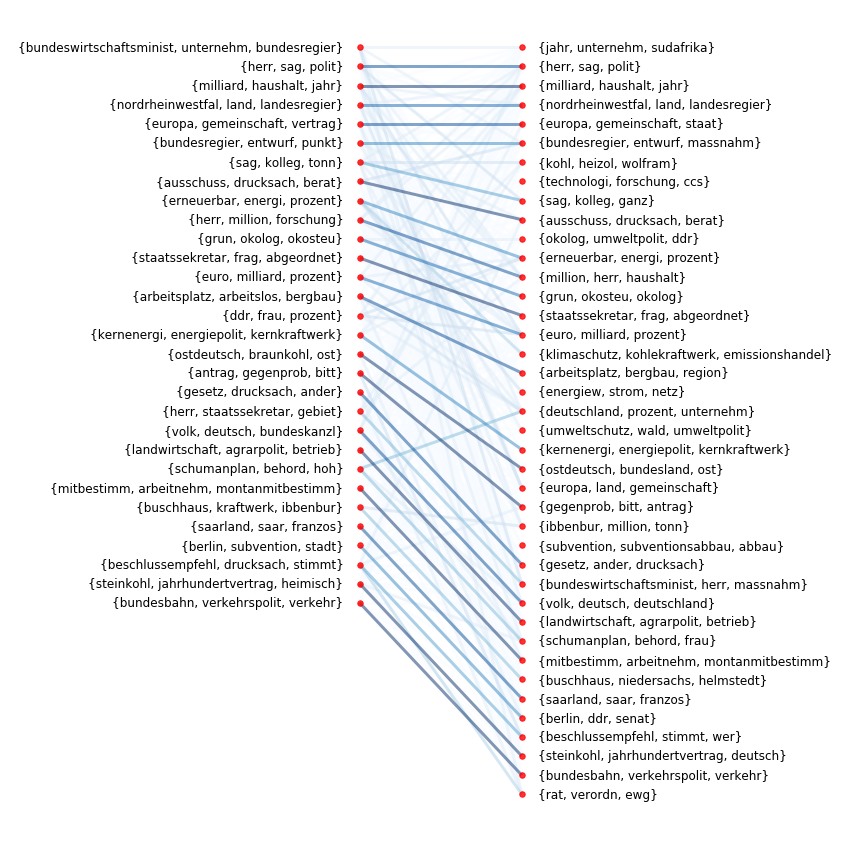

In [12]:
matrix1, permutation1 = sort_matrix(score_matrix)
topic_list1 = [topics1[int(permutation1[i])] for i in range(len(topics1))]

matrix2, permutation2 = sort_matrix(score_matrix)
#print(permutation)
g = bipartite_graph_from_matrix(matrix2, threshold=1)
perm_topic_list = [topics1[int(permutation2[i])].title for i in range(K1)]
draw_bipartite_topic_graph(g, perm_topic_list, topics2, filename='test_bipartite_topic_graph_K{}_K{}_topword_score'.format(K1, K2))